In [1]:
import torch
import torch.nn as nn 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
from pylab import rcParams
import statistics

#Reading data from csv file and calculating return price
df = pd.read_csv('UCLA.csv')
df = df.drop([0, 1,2, 3])
input_data = df[['Price', 'SMA', 'EMA', 'RSI']].values
targets = df['Price_Return'].values
print(targets.shape)

c:\Users\mostafa.shiri\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


(501,)


In [2]:
#We use T past values to predict next value
#Our data has D dimention (in this problem we have multidimentional data set)
T = 3
D = input_data.shape[1]
N = len(input_data) - T 
N_train = 2 * len(input_data) // 3
#Normalizing training data 
scaler = StandardScaler()
scaler.fit(input_data[: N_train + T -1])
input_data = scaler.transform(input_data)

In [3]:
#Now we start to build train data set and test data set
X_train = np.zeros((N_train, T, D))
Y_train = np.zeros((N_train, 1))
for i in range(N_train):
    X_train[i, :,:] = input_data[i:i+T]
    Y_train[i] = (targets[i+T] > 0) #Now the Y is boolean (it is no more regression problem!)

X_test = np.zeros((N - N_train, T, D))
Y_test = np.zeros((N - N_train, 1))
for j in range(N - N_train):
    t = j + N_train
    X_test[j, :,:] = input_data[t:t+T] #Input's indice of this list should be start from len(N_train)
    Y_test[j] = (targets[t+T] > 0)

In [4]:
#Thsi is our model. LSTM model with M hidden cells and L layers
class RNN(nn.Module):
    def __init__(self, n_inputs, n_hidden, n_rnnlayers, n_outputs):
        super(RNN, self).__init__()
        self.D = n_inputs
        self.M = n_hidden
        self.K = n_outputs
        self.L = n_rnnlayers

        self.rnn = nn.LSTM(
            input_size=self.D,
            hidden_size=self.M,
            num_layers=self.L,
            batch_first=True,
            dropout=0.5)
        self.fc = nn.Linear(self.M, self.K)
    
    def forward(self, X):
        h0 = torch.zeros(self.L, X.size(0), self.M)
        c0 = torch.zeros(self.L, X.size(0), self.M)
        out, _ = self.rnn(X, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out


In [5]:
#Now we call our model with arbitary inputs
#We define our loss function and optimizer
model = RNN(4, 20, 2, 1)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.7)
#We preare train and target data sets
X_train = torch.from_numpy(X_train.astype(np.float32))
y_train = torch.from_numpy(Y_train.astype(np.float32))
X_test = torch.from_numpy(X_test.astype(np.float32))
y_test = torch.from_numpy(Y_test.astype(np.float32))

In [6]:
#The trainig function (gradient descent)
def full_gd(model,
            criterion,
            optimizer, 
            X_train,
            y_train,
            X_test,
            y_test,
            epochs=500):

    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)

    for it in range(epochs):
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        train_losses [it] = loss.item()
        test_outputs = model(X_test)
        test_loss = criterion(test_outputs, y_test)
        test_losses[it] = test_loss.item()

        if (it + 1) % 5 == 0:
            print(f'Epoch {it + 1} / {epochs}, Train Loss: {loss.item(): .4f}, Test Loss : {test_loss.item(): .4f}')
    print(statistics.mean(test_losses))
    print(statistics.mean(train_losses))

    return train_losses, test_losses

In [7]:
#We call trainig function with defined inputs
train_losses, test_losses = full_gd(model,
                                    criterion,
                                    optimizer,
                                    X_train,
                                    y_train,
                                    X_test,
                                    y_test)

Epoch 5 / 500, Train Loss:  0.7344, Test Loss :  0.7750
Epoch 10 / 500, Train Loss:  0.7051, Test Loss :  0.6750
Epoch 15 / 500, Train Loss:  0.6507, Test Loss :  0.6524
Epoch 20 / 500, Train Loss:  0.5579, Test Loss :  0.6152
Epoch 25 / 500, Train Loss:  0.5461, Test Loss :  0.5811
Epoch 30 / 500, Train Loss:  0.5476, Test Loss :  0.5676
Epoch 35 / 500, Train Loss:  0.5062, Test Loss :  0.5964
Epoch 40 / 500, Train Loss:  0.5829, Test Loss :  0.5676
Epoch 45 / 500, Train Loss:  0.5587, Test Loss :  0.5623
Epoch 50 / 500, Train Loss:  0.5269, Test Loss :  0.5860
Epoch 55 / 500, Train Loss:  0.5190, Test Loss :  0.6047
Epoch 60 / 500, Train Loss:  0.5311, Test Loss :  0.6008
Epoch 65 / 500, Train Loss:  0.5502, Test Loss :  0.6211
Epoch 70 / 500, Train Loss:  0.5506, Test Loss :  0.6024
Epoch 75 / 500, Train Loss:  0.5649, Test Loss :  0.5599
Epoch 80 / 500, Train Loss:  0.5386, Test Loss :  0.5866
Epoch 85 / 500, Train Loss:  0.5569, Test Loss :  0.6155
Epoch 90 / 500, Train Loss:  0.4

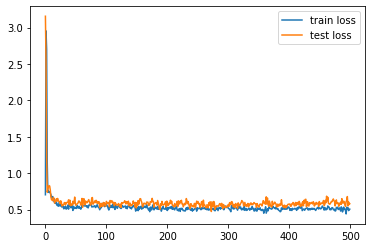

In [8]:
#Now we plot the test losses and train losses per iteration
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.rcParams['figure.figsize'] = 25, 6
plt.legend()
plt.show()

In [9]:
#Now we calculate train and test accuracy
with torch.no_grad():
    p_train = model(X_train)
    p_train = (p_train.cpu().numpy() > 0)
    train_acc = np.mean(y_train.cpu().numpy()  == p_train)

    p_test = model(X_test)
    p_test = (p_test.cpu().numpy() > 0)
    test_acc = np.mean(y_test.cpu().numpy()  == p_test)
print(f'Train_acc: {train_acc: .4f}, Test_acc: {test_acc: .4f}')

Train_acc:  0.7545, Test_acc:  0.6951
